# Model Training

We'll be proceeding in 4 phases to see if the data we've collected has sufficient predictive power, moving from a less to a more complex model until we get diminishing returns. Keep in mind that, the series we create will need to be split by Artist, not by date, since we want predictions on artists we've never seen before, ultimately strongely based on network.

## Phase 1: Data Exploration

1. Pre-requisite: Plot the data just to see if there are any obvious trends between artist_past_performance and rank_norm. Note that in the "preliminary analysis", we saw that artists with more collaborations definetely tended to have better to rank better on debut, but this is just a correlation and the plotting in this step deals with a different feature.
2. Check Pearson correlation and other basic features just to see that it's not 0

## Phase 2: Regression

1. Upon seeing the plot, train a basic regressive model (polynomial regression) to see if we can fit the data well.
2. Make residual plots of these fits with actual artist performance and see at what degree of polynomial we get diminishing returns.

## Phase 3: Use Engineered Features

Here, we use PageRank and Degree Centrality scores, in addition to artist_past_performance and features_past_performance, to see if we can get better error reduction. If so, then we have reason to believe that there's stronger relationships between artists that can be exploited, in which case we can move on to proper graph-based neural networks.

## Phase 4: GNN

Construct proper graph networks that use artist relationships as edges and artist features (PageRank and Degree Centrality, past performance, etc) as node features. This is where the large chunk of work that we did on the graphing early on in the project will come in handy. We'll start making use of the transformed `JSON` relationship files

## Phase 5: Testing

Test the accuracy for deployment.


### Phase 1

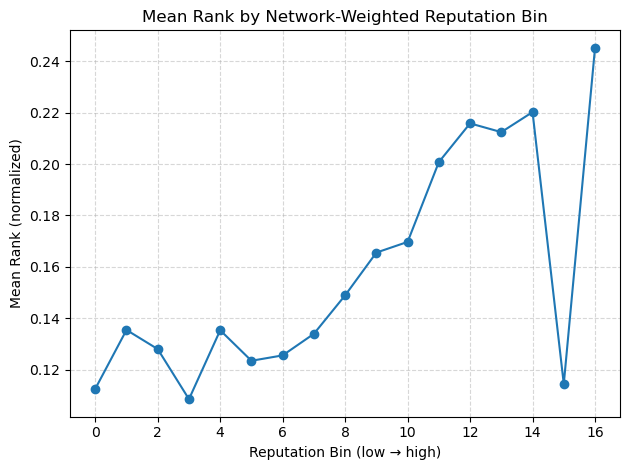

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

df = pd.read_csv("data/clean3.csv")[[
    "rank_norm",
    "artist_past_performance",
    "features_past_performance"
]]

alpha = 0.2  # collaborator weight
df["rep_weighted"] = (
    (1 - alpha) * df["artist_past_performance"]
    + alpha * df["features_past_performance"]
)

# 2D Scatter plot (useless)
# plt.scatter(df["rep_weighted"], df["rank_norm"], alpha=0.3)
# plt.xlabel("Weighted Reputation (Collaborators Heavy)")
# plt.ylabel("Rank (normalized)")
# plt.title("Rank vs. Network-Weighted Reputation")
# plt.grid(True, linestyle="--", alpha=0.5)
# plt.tight_layout()
# plt.show()


# Binned line plot
df["rep_bin"] = pd.qcut(df["rep_weighted"], q=20, duplicates="drop")
binned_means = df.groupby("rep_bin", observed=True)["rank_norm"].mean()

plt.plot(range(len(binned_means)), binned_means.values, marker="o")
plt.xlabel("Reputation Bin (low → high)")
plt.ylabel("Mean Rank (normalized)")
plt.title("Mean Rank by Network-Weighted Reputation Bin")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# pearson_corr = df[["rep_weighted", "rank_norm"]].corr(method="pearson")
# spearman_corr = df[["rep_weighted", "rank_norm"]].corr(method="spearman")

# print("Pearson correlation:")
# print(pearson_corr)
# print("\nSpearman correlation:")
# print(spearman_corr)

# y = df["rank_norm"].values

# def r2_of(cols):
#     X = df[cols].values
#     return LinearRegression().fit(X, y).score(X, y)

# r2_artist = r2_of(["artist_past_performance"])
# r2_collab = r2_of(["features_past_performance"])
# r2_both = r2_of(["artist_past_performance", "features_past_performance"])
# r2_weighted = r2_of(["rep_weighted"])

# print("\nR^2 scores:")
# print("Artist only:", r2_artist)
# print("Collaborators only:", r2_collab)
# print("Artist + Collaborators:", r2_both)
# print("Weighted reputation:", r2_weighted)


## Phase 2

Clearly, there's a 5th degree polynomial to fit the binned data well.

------------------------------
Fit Loss (MSE on Binned Means): 0.00853
True Loss (MSE on Raw Data):    0.02170
------------------------------


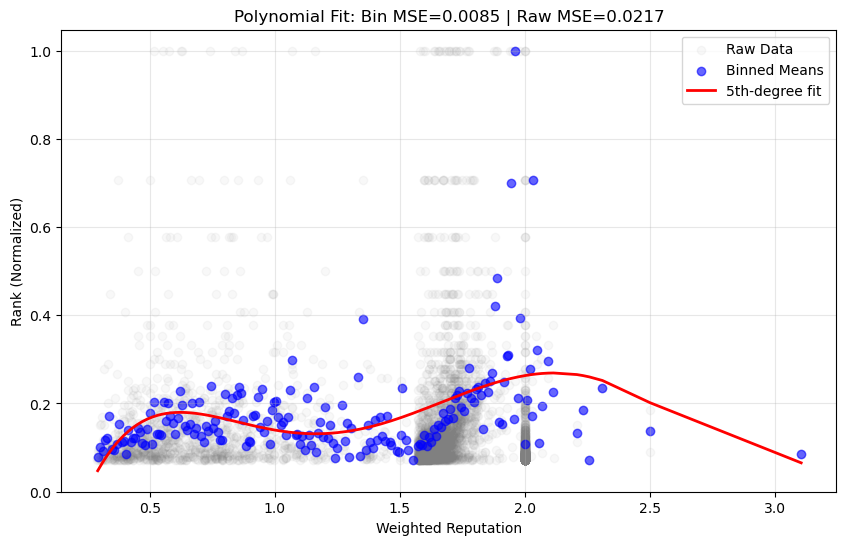

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 1. Load data
df = pd.read_csv("data/clean3.csv")[[
    "rank_norm",
    "artist_past_performance",
    "features_past_performance"
]]

# 2. Weighted reputation logic
COLLAB_WEIGHT = 3.0
df["rep_weighted"] = df["artist_past_performance"] + COLLAB_WEIGHT * df["features_past_performance"]

# 3. Bin the weighted reputation (Smoothing)
NUM_BINS = 300
bins = np.linspace(df["rep_weighted"].min(), df["rep_weighted"].max(), NUM_BINS + 1)
df["bin"] = np.digitize(df["rep_weighted"], bins)

# 4. Compute average rank per bin
binned = df.groupby("bin").agg(
    rep_weighted=("rep_weighted", "mean"),
    rank_mean=("rank_norm", "mean")
).dropna()

X_bin = binned[["rep_weighted"]].values
y_bin = binned["rank_mean"].values

# 5. Fit 5th-degree polynomial
poly = PolynomialFeatures(degree=5)
X_poly = poly.fit_transform(X_bin)

model = LinearRegression()
model.fit(X_poly, y_bin)

# 6. Predictions
# Predict on the bins (for the plot/fit error)
y_pred_bin = model.predict(X_poly)

# Predict on the raw original data (for true error)
X_raw = df[["rep_weighted"]].values
X_raw_poly = poly.transform(X_raw)
y_pred_raw = model.predict(X_raw_poly)

# 7. Compute and Print Losses
loss_bin = mean_squared_error(y_bin, y_pred_bin)
loss_raw = mean_squared_error(df["rank_norm"], y_pred_raw)

print("-" * 30)
print(f"Fit Loss (MSE on Binned Means): {loss_bin:.5f}")
print(f"True Loss (MSE on Raw Data):    {loss_raw:.5f}")
print("-" * 30)

# 8. Plot
plt.figure(figsize=(10, 6))
# Plot raw data (faint) to show the noise
plt.scatter(df["rep_weighted"], df["rank_norm"], alpha=0.05, color="gray", label="Raw Data")
# Plot binned averages
plt.scatter(X_bin, y_bin, alpha=0.6, color="blue", label="Binned Means")
# Plot the polynomial curve
plt.plot(X_bin, y_pred_bin, color="red", linewidth=2, label="5th-degree fit")

plt.xlabel("Weighted Reputation")
plt.ylabel("Rank (Normalized)")
plt.title(f"Polynomial Fit: Bin MSE={loss_bin:.4f} | Raw MSE={loss_raw:.4f}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Phase 3: Feature Addition

We see that the 5th-degree polynomial serves as a decent fit (both fit and true loss are very low). Now, let's quickly add the final engineered features to see if we can get an even better regressive fit.